In [2]:
import pandas as pd
import lightgbm as lgb
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70550, number of negative: 295664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 366214, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192647 -> initscore=-1.432902
[LightGBM] [Info] Start training from score -1.432902
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Num

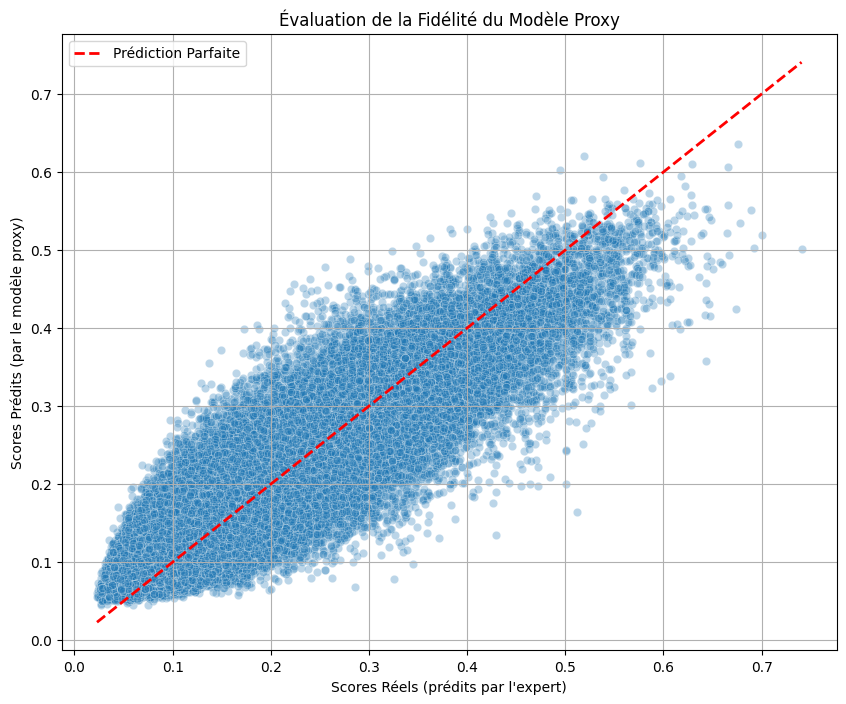

In [5]:
def train_expert_model(data_path, models_dir):
    input_path = os.path.join(data_path, "processed", "dataset_clean_no_outliers.parquet")
    df = pd.read_parquet(input_path)
    df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

    selected_features = [
        'term', 'annual_inc', 'dti', 'revol_util', 'revol_bal', 'loan_amnt', 
        'emp_length', 'home_ownership', 'purpose', 'verification_status', 
        'mort_acc', 'pub_rec', 'open_acc', 'total_acc'
    ]
    X = df[selected_features]
    y = df['is_default']
    X = pd.get_dummies(X, drop_first=True, dtype=float)

    model_1_neutral = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)
    
    model_1_neutral.fit(X, y)

    model_path = os.path.join(models_dir, "risk_model.pkl")
    cols_path = os.path.join(models_dir, "risk_model_columns.pkl")
    joblib.dump(model_1_neutral, model_path)
    joblib.dump(X.columns.tolist(), cols_path)

def train_proxy_model(data_path, models_dir):
    input_path = os.path.join(data_path, "processed", "dataset_clean_no_outliers.parquet")
    model_expert_path = os.path.join(models_dir, "risk_model.pkl")
    model_expert_cols_path = os.path.join(models_dir, "risk_model_columns.pkl")

    df = pd.read_parquet(input_path)
    model_expert_neutral = joblib.load(model_expert_path)
    model_expert_columns = joblib.load(model_expert_cols_path)

    selected_features_for_risk_model = [
        'term', 'annual_inc', 'dti', 'revol_util', 'revol_bal', 'loan_amnt', 
        'emp_length', 'home_ownership', 'purpose', 'verification_status', 
        'mort_acc', 'pub_rec', 'open_acc', 'total_acc'
    ]
    X_expert = df[selected_features_for_risk_model]
    X_expert = pd.get_dummies(X_expert, drop_first=True, dtype=float)
    X_expert = X_expert.reindex(columns=model_expert_columns, fill_value=0)
    y_target = model_expert_neutral.predict_proba(X_expert)[:, 1]

    features_for_proxy_simple = [
        'loan_amnt', 'annual_inc', 'term', 'dti', 'emp_length', 
        'home_ownership', 'purpose', 'verification_status'
    ]
    X_proxy = df[features_for_proxy_simple]
    X_proxy = pd.get_dummies(X_proxy, drop_first=True, dtype=float)

    X_train, X_test, y_train, y_test = train_test_split(X_proxy, y_target, test_size=0.2, random_state=42)

    proxy_model = lgb.LGBMRegressor(random_state=42)
    proxy_model.fit(X_train, y_train)

    y_pred = proxy_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n--- Performance du Modèle Proxy ---")
    print(f"Score R² (Fidélité) : {r2:.4f}")
    print(f"Erreur Absolue Moyenne (MAE) : {mae:.4f}")

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="Prédiction Parfaite")
    plt.xlabel("Scores Réels (prédits par l'expert)")
    plt.ylabel("Scores Prédits (par le modèle proxy)")
    plt.title("Évaluation de la Fidélité du Modèle Proxy")
    plt.legend()
    plt.grid(True)
    plt.show()

    proxy_model_path = os.path.join(models_dir, "chatbot_model.pkl")
    proxy_model_cols_path = os.path.join(models_dir, "chatbot_model_columns.pkl")
    joblib.dump(proxy_model, proxy_model_path)
    joblib.dump(X_proxy.columns.tolist(), proxy_model_cols_path)

if __name__ == "__main__":
    DATA_PATH = '../../data'
    MODELS_DIR = '../../models'
    
    os.makedirs(MODELS_DIR, exist_ok=True)
    
    train_expert_model(DATA_PATH, MODELS_DIR)
    train_proxy_model(DATA_PATH, MODELS_DIR)
